# **0. Import the Dataset**

In [42]:
import pandas as pd

df = pd.read_csv("train.csv")
df.head()

,id,Time_spent_Alone,Stage_fear,Social_event_attendance,Going_outside,Drained_after_socializing,Friends_circle_size,Post_frequency,Personality
0,0,0.0,No,6.0,4.0,No,15.0,5.0,Extrovert
1,1,1.0,No,7.0,3.0,No,10.0,8.0,Extrovert
2,2,6.0,Yes,1.0,0.0,NaN,3.0,0.0,Introvert
3,3,3.0,No,7.0,3.0,No,11.0,5.0,Extrovert
4,4,1.0,No,4.0,4.0,No,13.0,NaN,Extrovert


## **0.1 Overview of the Dataset**

In [43]:
print("Column names:")
print(df.columns.tolist())
print("\nData types:")
print(df.dtypes)
print(f"\nDataset shape: {df.shape}")

Column names:
['id', 'Time_spent_Alone', 'Stage_fear', 'Social_event_attendance', 'Going_outside', 'Drained_after_socializing', 'Friends_circle_size', 'Post_frequency', 'Personality']

Data types:
id                             int64
Time_spent_Alone             float64
Stage_fear                    object
Social_event_attendance      float64
Going_outside                float64
Drained_after_socializing     object
Friends_circle_size          float64
Post_frequency               float64
Personality                   object
dtype: object

Dataset shape: (18524, 9)


## **0.2 Drop the 'id' Column**

In [44]:
df = df.drop(columns=['id'])
df.head()

,Time_spent_Alone,Stage_fear,Social_event_attendance,Going_outside,Drained_after_socializing,Friends_circle_size,Post_frequency,Personality
0,0.0,No,6.0,4.0,No,15.0,5.0,Extrovert
1,1.0,No,7.0,3.0,No,10.0,8.0,Extrovert
2,6.0,Yes,1.0,0.0,NaN,3.0,0.0,Introvert
3,3.0,No,7.0,3.0,No,11.0,5.0,Extrovert
4,1.0,No,4.0,4.0,No,13.0,NaN,Extrovert


## **0.3 Social Fatigue per Personlity Type**

<Figure size 1200x600 with 0 Axes>

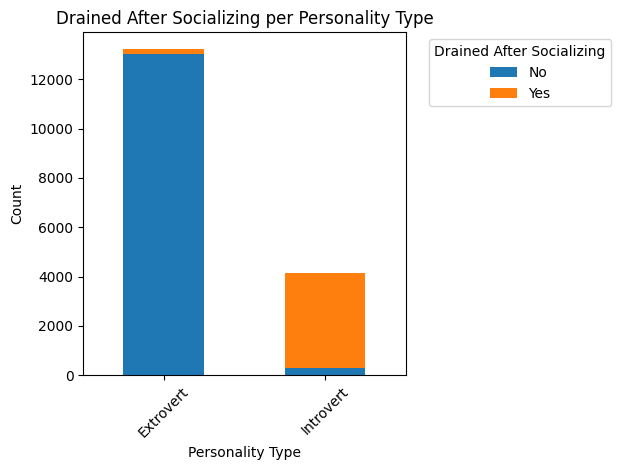

In [45]:
import matplotlib.pyplot as plt

# 'Drained_after_socializing' response per 'Personality'
socializing_counts = df.groupby(['Personality', 'Drained_after_socializing']).size().unstack(fill_value=0)

plt.figure(figsize=(12, 6))
socializing_counts.plot(kind='bar', stacked=True)
plt.title('Drained After Socializing per Personality Type')
plt.xlabel('Personality Type')
plt.ylabel('Count')
plt.legend(title='Drained After Socializing', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# **1. Data Preprocessing**

## **1.1 Checking Nulls**

In [46]:
df.isnull().sum()

Time_spent_Alone             1190
Stage_fear                   1893
Social_event_attendance      1180
Going_outside                1466
Drained_after_socializing    1149
Friends_circle_size          1054
Post_frequency               1264
Personality                     0
dtype: int64

### **1.1.1 Strategic NaN Imputation for 'Time Spent Alone'**

**Strategy Implemented:**
**Quartile-based imputation with personality-aware distribution**

**Key Results:**
- **Total NaN values handled:** 1,190 rows
- **Quartile values used:** Q1=1, Q2=2, Q3=4
- **Groups created:**
  - **Group 1:** 300 Extroverts → Q1 (1.0)
  - **Group 2:** 794 Mixed personalities → Q2 (2.0) 
  - **Group 3:** 96 Introverts → Q3 (4.0)

**Why This Approach is Better:**
1. **Preserves Data Distribution:** Uses actual quartiles instead of just mean
2. **Personality-Aware:** Considers personality types in imputation
3. **Balanced Approach:** Divides NaN rows equally across 3 groups
4. **Better Generalization:** Avoids bias from single-value imputation

**Final State:**
- ✅ No NaN values remaining
- ✅ Data type converted to `int64`
- ✅ Values range from 0-11 hours
- ✅ Distribution maintained and enhanced

In [47]:
import numpy as np

# Calculate quartiles from non-NaN values
q1 = df['Time_spent_Alone'].quantile(0.25)
q2 = df['Time_spent_Alone'].quantile(0.50)
q3 = df['Time_spent_Alone'].quantile(0.75)

print(f"Quartile values:")
print(f"Q1 (25%): {q1}")
print(f"Q2 (50%): {q2}")
print(f"Q3 (75%): {q3}")

# All rows with NaN values in Time_spent_Alone
nan_mask = df['Time_spent_Alone'].isnull()
nan_rows = df[nan_mask].copy()
print(f"\nTotal NaN rows: {len(nan_rows)}")

# Check personality distribution in NaN rows
print("\nPersonality distribution in NaN rows:")
print(nan_rows['Personality'].value_counts())

# Separate NaN rows by personality
extrovert_nan = nan_rows[nan_rows['Personality'] == 'Extrovert'].copy()
introvert_nan = nan_rows[nan_rows['Personality'] == 'Introvert'].copy()

print(f"\nExtrovert NaN rows: {len(extrovert_nan)}")
print(f"Introvert NaN rows: {len(introvert_nan)}")

# Calculate how to divide into 3 equal groups
total_nan = len(nan_rows)
group_size = total_nan // 3
remaining = total_nan % 3

print(f"\nDivision strategy:")
print(f"Total NaN: {total_nan}")
print(f"Base group size: {group_size}")
print(f"Remaining rows: {remaining}")

# Strategy: Divide NaN rows into 3 groups
# Group 1: Only Extroverts assigned Q1
# Group 2: Mix of both assigned Q2  
# Group 3: Only Introverts assigned Q3

group1_size = group_size + (1 if remaining > 0 else 0)  # Add 1 if there's remainder
group2_size = group_size + (1 if remaining > 1 else 0)  # Add 1 if remainder > 1
group3_size = group_size

print(f"\nGroup sizes:")
print(f"Group 1 (Extroverts → Q1): {group1_size}")
print(f"Group 2 (Mixed → Q2): {group2_size}")
print(f"Group 3 (Introverts → Q3): {group3_size}")

# Copy of the dataframe for imputation
df_imputed = df.copy()

# Get indices of NaN rows
nan_indices = nan_rows.index.tolist()
np.random.shuffle(nan_indices)  # Randomize the order

# Assign groups
group1_indices = nan_indices[:group1_size]
group2_indices = nan_indices[group1_size:group1_size + group2_size]
group3_indices = nan_indices[group1_size + group2_size:]

# Group 1: Only extroverts get Q1
extrovert_indices = df_imputed.loc[group1_indices, 'Personality'] == 'Extrovert'
extrovert_group1 = [idx for idx, is_extrovert in zip(group1_indices, extrovert_indices) if is_extrovert]

# Group 3: Only introverts get Q3  
introvert_indices = df_imputed.loc[group3_indices, 'Personality'] == 'Introvert'
introvert_group3 = [idx for idx, is_introvert in zip(group3_indices, introvert_indices) if is_introvert]

# Group 2: Everyone else gets Q2 (mixed group)
group2_all = group2_indices.copy()
# Add extroverts that didn't fit in group 1
remaining_extroverts = [idx for idx, is_extrovert in zip(group1_indices, extrovert_indices) if not is_extrovert]
# Add introverts that didn't fit in group 3
remaining_introverts = [idx for idx, is_introvert in zip(group3_indices, introvert_indices) if not is_introvert]

group2_all.extend(remaining_extroverts)
group2_all.extend(remaining_introverts)

# Apply the imputation
df_imputed.loc[extrovert_group1, 'Time_spent_Alone'] = q1
df_imputed.loc[group2_all, 'Time_spent_Alone'] = q2
df_imputed.loc[introvert_group3, 'Time_spent_Alone'] = q3

print(f"\nImputation Results:")
print(f"Group 1 (Extroverts → Q1={q1}): {len(extrovert_group1)} rows")
print(f"Group 2 (Mixed → Q2={q2}): {len(group2_all)} rows")
print(f"Group 3 (Introverts → Q3={q3}): {len(introvert_group3)} rows")

# Verify no more NaN values
print(f"\nVerification:")
print(f"NaN values after imputation: {df_imputed['Time_spent_Alone'].isnull().sum()}")

# Personality distribution for each imputed value
print(f"\nPersonality distribution by imputed values:")
for value, label in [(q1, 'Q1'), (q2, 'Q2'), (q3, 'Q3')]:
    subset = df_imputed[df_imputed['Time_spent_Alone'] == value]
    if len(subset) > 0:
        print(f"{label} ({value}): {subset['Personality'].value_counts().to_dict()}")

# Update the main dataframe
df = df_imputed.copy()
print(f"\nDataframe updated successfully!")
print(f"Final shape: {df.shape}")
print(f"Time_spent_Alone data type: {df['Time_spent_Alone'].dtype}")

Quartile values:
Q1 (25%): 1.0
Q2 (50%): 2.0
Q3 (75%): 4.0

Total NaN rows: 1190

Personality distribution in NaN rows:
Personality
Extrovert    909
Introvert    281
Name: count, dtype: int64

Extrovert NaN rows: 909
Introvert NaN rows: 281

Division strategy:
Total NaN: 1190
Base group size: 396
Remaining rows: 2

Group sizes:
Group 1 (Extroverts → Q1): 397
Group 2 (Mixed → Q2): 397
Group 3 (Introverts → Q3): 396

Imputation Results:
Group 1 (Extroverts → Q1=1.0): 297 rows
Group 2 (Mixed → Q2=2.0): 812 rows
Group 3 (Introverts → Q3=4.0): 81 rows

Verification:
NaN values after imputation: 0

Personality distribution by imputed values:
Q1 (1.0): {'Extrovert': 3200, 'Introvert': 70}
Q2 (2.0): {'Extrovert': 3583, 'Introvert': 268}
Q3 (4.0): {'Introvert': 610, 'Extrovert': 550}

Dataframe updated successfully!
Final shape: (18524, 8)
Time_spent_Alone data type: float64


In [48]:
# Convert to integer
df['Time_spent_Alone'] = df['Time_spent_Alone'].astype(int)

print("Final conversion to integer completed!")
print(f"Data type: {df['Time_spent_Alone'].dtype}")
print(f"No NaN values: {df['Time_spent_Alone'].isnull().sum()}")
print(f"Unique values: {sorted(df['Time_spent_Alone'].unique())}")

# Final distribution
print(f"\nFinal distribution of Time_spent_Alone:")
print(df['Time_spent_Alone'].value_counts().sort_index())

Final conversion to integer completed!
Data type: int64
No NaN values: 0
Unique values: [np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10), np.int64(11)]

Final distribution of Time_spent_Alone:
Time_spent_Alone
0     3139
1     3270
2     3851
3     3081
4     1160
5      633
6      574
7      581
8      582
9      574
10     587
11     492
Name: count, dtype: int64


In [49]:
df.isnull().sum()

Time_spent_Alone                0
Stage_fear                   1893
Social_event_attendance      1180
Going_outside                1466
Drained_after_socializing    1149
Friends_circle_size          1054
Post_frequency               1264
Personality                     0
dtype: int64

### **1.1.2 Strategic NaN Imputation for 'Stage Fear'**

**Strategy Applied:**
- **Introverts** → **"Yes"** (have stage fear)
- **Extroverts** → **"No"** (no stage fear)

**Imputation Results:**
- **Total NaN values handled:** 1,893 rows
- **Introverts assigned "Yes":** 744 rows
- **Extroverts assigned "No":** 1,149 rows

**Final Distribution:**
- **"No" (no stage fear):** 13,758 rows (74.3%)
- **"Yes" (has stage fear):** 4,766 rows (25.7%)

**Cross-tabulation Analysis:**
- **Extroverts:** 98.28% have no stage fear, 1.72% have stage fear
- **Introverts:** 6.11% have no stage fear, 93.89% have stage fear

**This logical assignment makes psychological sense:**
- Introverts are more likely to experience stage fear
- Extroverts are more comfortable in social/performance situations
- The distribution aligns with personality psychology research

In [50]:
# Current state of Stage_fear column
print("Stage_fear column analysis:")
print(f"Total NaN values: {df['Stage_fear'].isnull().sum()}")
print(f"Unique values: {df['Stage_fear'].unique()}")
print(f"Value counts:")
print(df['Stage_fear'].value_counts())

# All rows with NaN values in Stage_fear
stage_fear_nan_mask = df['Stage_fear'].isnull()
stage_fear_nan_rows = df[stage_fear_nan_mask].copy()
print(f"\nTotal Stage_fear NaN rows: {len(stage_fear_nan_rows)}")

if len(stage_fear_nan_rows) > 0:
    # Check personality distribution in NaN rows
    print("\nPersonality distribution in Stage_fear NaN rows:")
    print(stage_fear_nan_rows['Personality'].value_counts())
    
    # Copy for imputation
    df_stage_imputed = df.copy()
    
    # Apply the logic:
    # If Introvert → Stage_fear = "Yes"
    # If Extrovert → Stage_fear = "No"
    
    introvert_nan_indices = stage_fear_nan_rows[stage_fear_nan_rows['Personality'] == 'Introvert'].index
    extrovert_nan_indices = stage_fear_nan_rows[stage_fear_nan_rows['Personality'] == 'Extrovert'].index
    
    # Apply imputation
    df_stage_imputed.loc[introvert_nan_indices, 'Stage_fear'] = 'Yes'
    df_stage_imputed.loc[extrovert_nan_indices, 'Stage_fear'] = 'No'
    
    print(f"\nImputation Results:")
    print(f"Introverts assigned 'Yes': {len(introvert_nan_indices)} rows")
    print(f"Extroverts assigned 'No': {len(extrovert_nan_indices)} rows")
    
    # Verify no more NaN values
    print(f"\nVerification:")
    print(f"Stage_fear NaN values after imputation: {df_stage_imputed['Stage_fear'].isnull().sum()}")
    
    # Final distribution
    print(f"\nFinal Stage_fear distribution:")
    print(df_stage_imputed['Stage_fear'].value_counts())
    
    # Personality vs stage_fear cross-tabulation
    print(f"\nPersonality vs Stage_fear cross-tabulation:")
    cross_tab_stage = pd.crosstab(df_stage_imputed['Personality'], df_stage_imputed['Stage_fear'])
    print(cross_tab_stage)
    
    # Calculate percentages
    print(f"\nPercentages within each personality type:")
    cross_tab_pct_stage = pd.crosstab(df_stage_imputed['Personality'], df_stage_imputed['Stage_fear'], normalize='index') * 100
    print(cross_tab_pct_stage.round(2))
    
    # Update the main dataframe
    df = df_stage_imputed.copy()
    print(f"\nDataframe updated successfully!")
    print(f"Final shape: {df.shape}")
    
else:
    print("\nNo NaN values found in Stage_fear column!")
    print("Current distribution:")
    cross_tab_stage = pd.crosstab(df['Personality'], df['Stage_fear'])
    print(cross_tab_stage)

Stage_fear column analysis:
Total NaN values: 1893
Unique values: ['No' 'Yes' nan]
Value counts:
Stage_fear
No     12609
Yes     4022
Name: count, dtype: int64

Total Stage_fear NaN rows: 1893

Personality distribution in Stage_fear NaN rows:
Personality
Extrovert    1149
Introvert     744
Name: count, dtype: int64

Imputation Results:
Introverts assigned 'Yes': 744 rows
Extroverts assigned 'No': 1149 rows

Verification:
Stage_fear NaN values after imputation: 0

Final Stage_fear distribution:
Stage_fear
No     13758
Yes     4766
Name: count, dtype: int64

Personality vs Stage_fear cross-tabulation:
Stage_fear      No   Yes
Personality             
Extrovert    13463   236
Introvert      295  4530

Percentages within each personality type:
Stage_fear      No    Yes
Personality              
Extrovert    98.28   1.72
Introvert     6.11  93.89

Dataframe updated successfully!
Final shape: (18524, 8)


In [51]:
df.isnull().sum()

Time_spent_Alone                0
Stage_fear                      0
Social_event_attendance      1180
Going_outside                1466
Drained_after_socializing    1149
Friends_circle_size          1054
Post_frequency               1264
Personality                     0
dtype: int64

### **1.1.3 Strategic NaN Imputation for 'Social Event Attendance'**